Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

Explain why that might be happening. Are the localized translations really worse?

If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')
data = pd.merge(test, user, left_on='user_id', right_on='user_id')

In [7]:
data.head()


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [8]:
data.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [9]:
data.select_dtypes(['object']).describe()

,date,source,device,browser_language,ads_channel,browser,sex,country
count,452867,452867,452867,452867,181693,452867,452867,452867
unique,5,3,2,3,5,7,2,17
top,2015-12-04,Ads,Web,ES,Facebook,Android_App,M,Mexico
freq,141024,181693,251316,377160,68358,154977,264485,128484


In [38]:
data.country.unique()

array(['Spain', 'Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Costa Rica', 'Chile',
       'Argentina', 'Ecuador', 'Guatemala', 'Honduras', 'Paraguay',
       'Panama'], dtype=object)

In [49]:
data = data[data.country != 'Spain']
data.shape

(401085, 12)

In [108]:
data.browser_language.value_counts()

ES       334014
EN        55883
Other     11188
Name: browser_language, dtype: int64

## Confirming results

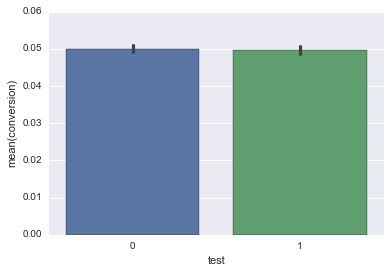

In [107]:
data_f = data[data.country != 'Argentina']
sns.barplot(x='test', y='conversion')

In [52]:
import scipy.stats as st

base, variant = data[data.test == 0], data[data.test == 1]
st.binom.cdf(variant[data.conversion == 1].shape[0], variant.shape[0], base.conversion.mean())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


3.12262211830749e-27

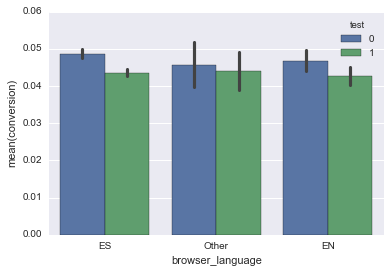

In [110]:
sns.barplot(data=data, x='browser_language', y='conversion', hue='test')

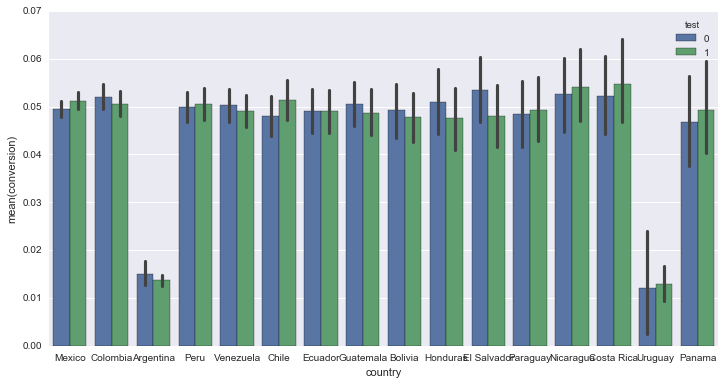

In [74]:
plt.figure(figsize=(12,6))
order = data.country.value_counts()
sns.barplot(data=data, x='country', y='conversion', hue='test', order=order.index)
# sns.countplot(data=data, x='country', order=order.index, right=True)

In [120]:
by_country = ( data
              .groupby([ 'country', 'test' ]).conversion
              .agg([ 'count', lambda x: sum(x == 1) ])
              .reset_index()
              .pivot(index='country', columns='test') )
by_country.columns = [ '_'.join(map(str, col)).strip() for col in by_country.columns.values]

In [123]:
def gtest(row):
    return st.binom.cdf( row[3], row[1], float(row[2])/row[0] )

by_country['gtest']  = by_country.apply(gtest, axis=1)
by_country['better'] = by_country.apply(lambda x: float(x[2])/x[0] < float(x[3])/x[1], axis=1)
by_country.sort('<lambda>_0', ascending=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count_0,count_1,<lambda>_0,<lambda>_1,gtest,better
country,,,,,,
Mexico,64209,64275,3178,3290,0.976066,True
Colombia,27088,26972,1411,1364,0.133585,False
Peru,16869,16797,842,850,0.667433,True
Venezuela,16149,15905,813,779,0.221488,False
Chile,9853,9884,474,507,0.932666,True
Ecuador,8036,7859,395,385,0.486480,False
Guatemala,7622,7503,386,365,0.223999,False
Bolivia,5550,5574,274,267,0.319922,False
Honduras,4361,4207,222,200,0.169171,False


## Explain

In [70]:
from sklearn.linear_model import *

x  = data.columns[~data.columns.isin(['conversion', 'user_id', 'date'])]
df = pd.get_dummies(data[x])

lr = LogisticRegression()
lr.fit(df, data.conversion)
lr.score(df, data.conversion)

0.95433386937930864

In [71]:
import statsmodels.api as sm

mod = sm.Logit(data.conversion, df)
res = mod.fit_regularized(alpha=0.001)

res.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18331382478
            Iterations: 182
            Function evaluations: 188
            Gradient evaluations: 182
QC check did not pass for 40 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:               401085
Model:                          Logit   Df Residuals:                   401045
Method:                           MLE   Df Model:                           39
Date:                Sat, 03 Jun 2017   Pseudo R-squ.:                 0.01206
Time:                        11:27:27   Log-Likelihood:                -73524.
converged:                       True   LL-Null:                       -74422.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
test                       0.0030      0.015      0.197      0.844        -0.027     0.033
age                        0.0002      0.001      0.148      0.883        -0.002     0.002
source_Ads                -0.5865        nan        nan        nan           nan       nan
source_Direct             -0.5945        nan        nan        nan           nan       nan
source_SEO                -0.5999        nan        nan        nan           nan       nan
device_Mobile             -0.7634        nan        nan        nan           nan       nan
device_Web                -0.9742        nan        nan        nan           nan       nan
browser_language_EN       -0.3739        nan        nan        nan           nan       nan
browser_language_ES       -0.3413        nan        nan        nan           nan       nan
browser_language_Other    -0.3639        nan        nan        nan           nan       nan
ads_channel_Bing          -0.0523        nan        nan        nan           nan       nan
ads_channel_Facebook       0.0225        nan        nan        nan           nan       nan
ads_channel_Google        -0.0104        nan        nan        nan           nan       nan
ads_channel_Other         -0.1603        nan        nan        nan           nan       nan
ads_channel_Yahoo          0.0046        nan        nan        nan           nan       nan
browser_Android_App       -0.3567        nan        nan        nan           nan       nan
browser_Chrome            -0.1559        nan        nan        nan           nan       nan
browser_FireFox           -0.1567        nan        nan        nan           nan       nan
browser_IE                -0.1738        nan        nan        nan           nan       nan
browser_Iphone_App        -0.3421        nan        nan        nan           nan       nan
browser_Opera             -0.0502        nan        nan        nan           nan       nan
browser_Safari            -0.2097        nan        nan        nan           nan       nan
sex_F                     -0.9561        nan        nan        nan           nan       nan
sex_M                     -0.9563        nan        nan        nan           nan       nan
country_Argentina         -1.2358        nan        nan        nan           nan       nan
country_Bolivia            0.0479        nan        nan        nan           nan       nan
country_Chile              0.0699        nan        nan        nan           nan       nan
country_Colombia           0.1043        nan        nan        nan           nan       nan
country_Costa Rica         0.1474        nan        nan        nan           nan       nan
country_Ecuador            0.0572        nan        nan        nan           nan       nan
country_El Salvador        0.0918        nan        nan        nan           nan       nan
country_Guatemala          0.0685        nan        nan        nan           nan       nan
country_Honduras           0.0599        nan        nan 

Not randomized on Argentina

## Solution

In [149]:
validation = pd.DataFrame()
for c in data_f[x].select_dtypes([ 'object' ]).columns:
    tmp = ( data_f.groupby([ c, 'test' ]).conversion.count()
            .reset_index().pivot(index=c, columns='test') )
    tmp.columns  = tmp.columns.get_level_values(1)
    tmp.index    = [ "%s_%s" % (c,i) for i in tmp.index ]
    tmp['gtest'] = tmp.apply(lambda x: st.binom.cdf( x[1], x[0]+x[1], 0.5 ), axis=1 )
    tmp['wrong'] = tmp['gtest'] > 0.9999
    validation   = pd.concat([ validation, tmp ])
validation

test,0,1,gtest,wrong
source_Ads,70582,71463,0.990364,False
source_Direct,35386,35490,0.653358,False
source_SEO,69987,71444,0.999947,True
device_Mobile,78198,79506,0.999510,False
device_Web,97757,98891,0.994759,False
browser_language_EN,24486,24978,0.986678,False
browser_language_ES,146623,148394,0.999448,False
browser_language_Other,4846,5025,0.964988,False
ads_channel_Bing,5274,5390,0.871391,False
ads_channel_Facebook,26480,26953,0.979846,False
